In [2]:
using Pkg; Pkg.add(url="https://github.com/grayseff/MCMachineLearningPotentialInterface.jl.git")
Pkg.update()

using ParallelTemperingMonteCarlo,BenchmarkTools,DelimitedFiles,MCMachineLearningPotentialInterface,Random

    Updating git-repo `https://github.com/grayseff/MCMachineLearningPotentialInterface.jl.git`


   Resolving package versions...


    Updating `~/Documents/ParallelTemperingMonteCarlo.jl/Project.toml`
  [3c6de921] + MCMachineLearningPotentialInterface v1.0.0 `https://github.com/grayseff/MCMachineLearningPotentialInterface.jl.git#main`
    Updating `~/Documents/ParallelTemperingMonteCarlo.jl/Manifest.toml`


  [da1fd8a2] + CodeTracking v1.3.1
  [41ab1584] + InvertedIndices v1.3.0
  [aa1ae85d] + JuliaInterpreter v0.9.23
  [6f1432cf] + LoweredCodeUtils v2.3.0
  [3c6de921] + MCMachineLearningPotentialInterface v1.0.0 `https://github.com/grayseff/MCMachineLearningPotentialInterface.jl.git#main`
  [295af30f] + Revise v3.5.3


    Updating git-repo `https://github.com/grayseff/MCMachineLearningPotentialInterface.jl.git`


  No Changes to `~/Documents/ParallelTemperingMonteCarlo.jl/Project.toml`
  No Changes to `~/Documents/ParallelTemperingMonteCarlo.jl/Manifest.toml`


In [2]:
using SplitApplyCombine

Completed the MLP module based on the librunner.so file written by A. Knoll. Time to use this in PTMC simulations so I can finally generate results. This requires the librunnerjulia file and use of the MLP package.

First: establishing the struct.

This requires the symmetry functions, the nnp values itself, the g and f matrices used in the calculation and a dummy vector new_f_vec to preassign memory for later. I'd prefer to point to the nnp and symmetryfunction structs rather than save copies, I'll look into this later. 

In [3]:
# struct  RuNNerPotential <: AbstractMachineLearningPotential
#     nnp::NeuralNetworkPotential
#     symmetryfunctions::Vector{AbstractSymmFunction}
#     r_cut::Float64
# end
# function RuNNerPotential(nnp,symmetryfunction)
#     r_cut = symmetryfunction[1].r_cut
#     return RuNNerPotential(nnp,symmetryfunction,r_cut)
# end


The challenge is potentials are not unique to each given state, meaning that g_matrix, f_matrix need to be part of the mc_state, not necessarily part of an immutable potential. They could be a vector of these matrices but this seems prohibitive. It's possible to assign them to mc_states? Have an NNP subtype?


In [4]:
# mutable struct NNPState{T,N,BC}
#     temp::T
#     beta::T
#     config::Config{N,BC,T}
#     dist2_mat::Matrix{T}
#     en_atom_vec::Vector{T}
#     en_tot::T
#     ham::Vector{T}
#     max_displ::Vector{T}
#     count_atom::Vector{Int}
#     count_vol::Vector{Int}
#     count_rot::Vector{Int}
#     count_exc::Vector{Int}

#     new_en_atom::Vector{T}

#     g_matrix::Array{T}
#     f_matrix::Array{T}

#     new_g_matrix::Array{T}
#     new_dist2_vec::Vector{T}
#     new_f_vec::Vector{T}
# end


# function NNPState(
#     temp, beta, config::Config{N,BC,T}, dist2_mat, en_atom_vec, en_tot,n_symm_func,g_matrix,f_matrix; 
#     max_displ = [0.1,0.1,1.], count_atom = [0,0], count_vol = [0,0], count_rot = [0,0], count_exc = [0,0]
# ) where {T,N,BC}
#     ham = T[]
#     NNPState{T,N,BC}(
#         temp, beta, deepcopy(config), copy(dist2_mat), copy(en_atom_vec), en_tot, 
#         ham, copy(max_displ), copy(count_atom), copy(count_vol), copy(count_rot), copy(count_exc),zeros(length(config.pos)),g_matrix,f_matrix,zeros(n_symm_func,length(config.pos)),zeros(length(config.pos)),zeros(length(config.pos))
#         )
# end
# function NNPState(temp,beta, config::Config, pot::RuNNerPotential;kwargs...)
#     dist2_mat = get_distance2_mat(config)
#     f_matrix = cutoff_function.(sqrt.(dist2_mat),Ref(pot.r_cut))
#     n_atoms = length(config.pos)
#     g_matrix = total_symm_calc(config.pos,dist2_mat,f_matrix,pot.symmetryfunctions)


#     en_atom_vec = zeros(n_atoms)
#     en_tot = 0.

#     NNPState(temp, beta, config, dist2_mat, en_atom_vec, en_tot,length(pot.symmetryfunctions),g_matrix,f_matrix ; kwargs...)

# end

Functionally, this definition allows us to initialise the runner potential, the state and then use them to define the new potential specific state with the g_matrix included. 

In [5]:
# function initial_energy_calculation(nnp_state,runner_pot)
#     n_atoms = length(nnp_state.config.pos)

#     nnp_state.g_matrix = total_symm_calc(nnp_state.config.pos,nnp_state.dist2_mat,nnp_state.f_matrix,runner_pot.symmetryfunctions)

#     nnp_state.en_atom_vec = forward_pass(nnp_state.g_matrix,n_atoms,runner_pot.nnp)

#     nnp_state.en_tot = sum(nnp_state.en_atom_vec)

#     return nnp_state
# end

Critically, we require the get_energy function as defined in energyevaluation. Once this is done, we can simulate NNP's. 

Note-- This is done with the following input/output

input:  trial_positions,indices,mc_states,pot

the new positions, the new indices for them, the current states and the potential.

output:  energy_vector, dist2_new




In [6]:
# function get_new_state_vars!(trial_pos,atomindex,nnp_state,pot)
#     nnp_state.new_dist2_vec = [ distance2(trial_pos,b,nnp_state.config.bc) for b in nnp_state.config.pos]

#     nnp_state.new_dist2_vec[atomindex] = 0.
    
#     nnp_state.new_f_vec = cutoff_function.(sqrt.(nnp_state.new_dist2_vec),Ref(pot.r_cut))


#     nnp_state.new_g_matrix = copy(nnp_state.g_matrix)

#     nnp_state.new_g_matrix = total_thr_symm!(nnp_state.new_g_matrix,nnp_state.config.pos,trial_pos,nnp_state.dist2_mat,nnp_state.new_dist2_vec,nnp_state.f_matrix,nnp_state.new_f_vec,atomindex,pot.symmetryfunctions)

#     return nnp_state
# end

# function calc_new_energy!(nnp_state,pot)
#     nnp_state.new_en_atom = forward_pass(nnp_state.new_g_matrix,length(nnp_state.en_atom_vec),pot.nnp)
#     return nnp_state
# end

# function get_runner_energy!(trial_pos,atomindex,nnp_state,pot)
#     nnp_state = get_new_state_vars!(trial_pos,atomindex,nnp_state,pot)

#     nnp_state = calc_new_energy!(nnp_state,pot)
    
#     return sum(nnp_state.new_en_atom) , nnp_state
# end

# function get_energy!(trial_positions,indices,nnp_states,pot::RuNNerPotential)
#     energyvector = Vector{Float64}(undef,length(indices))
#     # for idx in eachindex(nnp_states)
#     #     energyvector[idx],nnp_states[idx] = get_runner_energy!(trial_positions[idx],indices[idx],nnp_states[idx],pot)
#     # end
#     energyvector,nnp_states = invert(get_runner_energy!.(trial_positions,indices,nnp_states,Ref(pot)))
    
#     return energyvector, nnp_states
# end

Ideally the function above now works the way it's intended in the simulation, other than the natural output being different from other methods. As a result of this we may want to have the g_new_matrix being part of the nnp_state struct, as it preserves the total form of the mc_step function

# Initialisation 

The next major step is to implement a more definitive initialisation. This is somewhat restricted by the purge of .data files, but we can point to directories containing the weights and scaling data. 

Beyond this we need to point to symmetry function values, distributed over sets of atom types. 

In [7]:
#-------------------------------------------#
#--------Vector of radial symm values-------#
#-------------------------------------------#
X = [ 1    1              0.001   0.000  11.338
 1    0              0.001   0.000  11.338
 1    1              0.020   0.000  11.338
 1    0              0.020   0.000  11.338
 1    1              0.035   0.000  11.338
 1    0              0.035   0.000  11.338
 1    1              0.100   0.000  11.338
 1    0              0.100   0.000  11.338
 1    1              0.400   0.000  11.338
 1    0              0.400   0.000  11.338]

radsymmvec = []


#--------------------------------------------#
#--------Vector of angular symm values-------#
#--------------------------------------------#
V = [[0.0001,1,1,11.338],[0.0001,-1,2,11.338],[0.003,-1,1,11.338],[0.003,-1,2,11.338],[0.008,-1,1,11.338],[0.008,-1,2,11.338],[0.008,1,2,11.338],[0.015,1,1,11.338],[0.015,-1,2,11.338],[0.015,-1,4,11.338],[0.015,-1,16,11.338],[0.025,-1,1,11.338],[0.025,1,1,11.338],[0.025,1,2,11.338],[0.025,-1,4,11.338],[0.025,-1,16,11.338],[0.025,1,16,11.338],[0.045,1,1,11.338],[0.045,-1,2,11.338],[0.045,-1,4,11.338],[0.045,1,4,11.338],[0.045,1,16,11.338],[0.08,1,1,11.338],[0.08,-1,2,11.338],[0.08,-1,4,11.338],[0.08,1,4,11.338]]

T = [[1.,1.,1.],[1.,1.,0.],[1.,0.,0.]]

angularsymmvec = []
#-------------------------------------------#
#-----------Including scaling data----------#
#-------------------------------------------#
file = open("$(pwd())/scaling.data")
scalingvalues = readdlm(file)
close(file)
G_value_vec = []
for row in eachrow(scalingvalues[1:88,:])
    max_min = [row[4],row[3]]
    push!(G_value_vec,max_min)
end


for symmindex in eachindex(eachrow(X))
    row = X[symmindex,:]
    radsymm = RadialType2{Float64}(row[3],row[5],[row[1],row[2]],G_value_vec[symmindex])
    push!(radsymmvec,radsymm)
end

n_index = 10
for element in V
    for types in T 
        
        n_index += 1

        symmfunc = AngularType3{Float64}(element[1],element[2],element[3],11.338,types,G_value_vec[n_index])

        push!(angularsymmvec,symmfunc)
    end
end
#---------------------------------------------------#
#------concatenating radial and angular values------#
#---------------------------------------------------#

totalsymmvec = vcat(radsymmvec,angularsymmvec)


#--------------------------------------------------#
#-----------Initialising the nnp weights-----------#
#--------------------------------------------------#
num_nodes::Vector{Int32} = [88, 20, 20, 1]
activation_functions::Vector{Int32} = [1, 2, 2, 1]
file = open("weights.029.data","r+")
weights=readdlm(file)
close(file)
weights = vec(weights)
nnp = NeuralNetworkPotential(num_nodes,activation_functions,weights)

runnerpotential = RuNNerPotential(nnp,totalsymmvec)

RuNNerPotential(NeuralNetworkPotential(4, 2221, Int32[88, 20, 20, 1], Int32[1, 2, 2, 1], [-1.0768943782, 0.3563458393, -1.3084861447, 0.1127640916, -0.5646591931, -0.4969830793, 1.423770514, -0.2005662393, -0.8957859374, 0.6076110858  …  0.1939524848, -0.0342903191, -0.0231042009, 0.0718481968, -0.0828320122, -0.0728501885, 0.0306628826, 0.0486053813, -0.0867018862, 0.0441651841]), AbstractSymmFunction[RadialType2{Float64}(0.001, 11.338, [1.0, 1.0], -0.029892621990594427, 0.06634475788973929), RadialType2{Float64}(0.001, 11.338, [1.0, 0.0], -0.0, 0.09828103647521905), RadialType2{Float64}(0.02, 11.338, [1.0, 1.0], -0.013430592462258787, 0.13321466604629645), RadialType2{Float64}(0.02, 11.338, [1.0, 0.0], -0.0, 0.18618835781674212), RadialType2{Float64}(0.035, 11.338, [1.0, 1.0], -0.0067056953127401205, 0.2093521117141925), RadialType2{Float64}(0.035, 11.338, [1.0, 0.0], -0.0, 0.28571045376567983), RadialType2{Float64}(0.1, 11.338, [1.0, 1.0], -0.00026435144512647774, 0.9364998977117353

In [8]:
Random.seed!(1234)
n_atoms = 55
ti = 600
tf = 950
n_traj = 20
temp = TempGrid{n_traj}(ti,tf) 
mc_cycles = 250
mc_sample = 1
displ_atom = 0.1 # Angstrom
n_adjust = 100
max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)
move_strat = MoveStrategy(atom_moves = n_atoms) 
ensemble = NVT(n_atoms)
ico_55 = [[0.0000006584,       -0.0000019175,        0.0000000505],
[-0.0000005810,       -0.0000004871,        0.6678432175],
[0.1845874248,       -0.5681026047,        0.2986701538],
[-0.4832557457,       -0.3511072166,        0.2986684497],
[-0.4832557570,        0.3511046452,        0.2986669456],
[0.1845874064,        0.5681000550,        0.2986677202],
[0.5973371920,       -0.0000012681,        0.2986697030],
[-0.1845860897,       -0.5681038901,       -0.2986676192],
[-0.5973358752,       -0.0000025669,       -0.2986696020],
[-0.1845861081,        0.5680987696,       -0.2986700528],
[0.4832570624,        0.3511033815,       -0.2986683486],
[0.4832570738,       -0.3511084803,       -0.2986668445],
[0.0000018978,       -0.0000033480,       -0.6678431165],
[-0.0000017969,        0.0000009162,        1.3230014650],
[0.1871182835,       -0.5758942175,        0.9797717078],
[-0.4898861924,       -0.3559221410,       0.9797699802],
[-0.4898862039,        0.3559224872,        0.9797684555],
[0.1871182648,        0.5758945856,        0.9797692407],
[0.6055300485,        0.0000001908,        0.9797712507],
[0.7926501864,       -0.5758950093,        0.6055339635],
[0.3656681761,       -1.1254128670,        0.5916673591],
[-0.3027660545,       -0.9318173412,        0.6055326929],
[-0.9573332453,       -0.6955436707,        0.5916639831],
[-0.9797705418,       -0.0000006364,        0.6055294407],
[-0.9573332679,        0.6955423392,        0.5916610035],
[-0.3027660847,        0.9318160902,        0.6055287012],
[0.3656681396,        1.1254115783,        0.5916625380],
[0.7926501677,        0.5758937939,        0.6055314964],
[1.1833279992,       -0.0000006311,        0.5916664660],
[0.6770051458,       -0.9318186223,        0.0000033028],
[0.0000006771,       -1.1517907207,        0.0000025175],
[-0.6770037988,       -0.9318186442,        0.0000007900],
[-1.0954155825,       -0.3559242494,       -0.0000012200],
[-1.0954155940,        0.3559203788,       -0.0000027447],
[-0.6770038290,        0.9318147872,       -0.0000032017],
[0.0000006397,        1.1517868856,       -0.0000024165],
[0.6770051155,        0.9318148091,       -0.0000006889],
[1.0954168993,        0.3559204143,        0.0000013211],
[1.0954169108,       -0.3559242139,        0.0000028458],
[0.3027674014,       -0.9318199253,       -0.6055286002],
[-0.3656668229,       -1.1254154134,       -0.5916624370],
[-0.7926488510,       -0.5758976290,       -0.6055313954],
[-1.1833266824,       -0.0000032040,       -0.5916663649],
[-0.7926488697,        0.5758911742,       -0.6055338624],
[-0.3656668594,        1.1254090319,       -0.5916672580],
[0.3027673712,        0.9318135061,       -0.6055325919],
[0.9573345621,        0.6955398357,       -0.5916638820],
[0.9797718586,       -0.0000031986,       -0.6055293396],
[0.9573345846,       -0.6955461743,       -0.5916609025],
[-0.1871169480,       -0.5758984207,       -0.9797691397],
[-0.6055287318,       -0.0000040259,       -0.9797711497],
[-0.1871169667,        0.5758903824,       -0.9797716067],
[0.4898875091,        0.3559183059,       -0.9797698792],
[0.4898875207,       -0.3559263223,       -0.9797683545],
[0.0000031136,       -0.0000047513,       -1.3230013639]]
#convert to Bohr
nmtobohr = 18.8973
copperconstant = 0.36258*nmtobohr
pos_cu55 = copperconstant*ico_55

AtoBohr = 1.8897259886
bc_cu55 = SphericalBC(radius=12*AtoBohr)
start_config = Config(pos_cu55, bc_cu55)
n_bin = 100

mc_states = [NNPState(temp.t_grid[i], temp.beta_grid[i], start_config, runnerpotential; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)


Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Matrix{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

benchmarking revealed this is faster.

In [9]:
# function initial_energy_vec(nnp_states,potential)
#     nnp_states = initial_energy_calculation.(nnp_states,Ref(potential))
#     return nnp_states
# end
function initial_energy_vec(nnp_states,potential)
    # nnp_states = initial_energy_calculation.(nnp_states,Ref(potential))
    for state in nnp_states 
        state = initial_energy_calculation(state,potential)
    end
    return nnp_states
end

initial_energy_vec (generic function with 1 method)

In [10]:
mc_states = initial_energy_vec(mc_states,runnerpotential)
mc_states[2].en_tot

UndefVarError: UndefVarError: initial_energy_calculation not defined

In [11]:
# function testswap_config!(nnp_state,atomindex,trial_pos,new_energy)

#     nnp_state.config.pos[atomindex] = trial_pos

#     nnp_state.dist2_mat[atomindex,:] = nnp_state.new_dist2_vec
#     nnp_state.dist2_mat[:,atomindex] = nnp_state.new_dist2_vec

#     nnp_state.f_matrix[atomindex,:] = nnp_state.new_f_vec
#     nnp_state.f_matrix[:,atomindex] = nnp_state.new_f_vec

#     nnp_state.g_matrix = nnp_state.new_g_matrix

#     nnp_state.en_atom_vec = nnp_state.new_en_atom
#     nnp_state.en_tot = new_energy

#     nnp_state.count_atom[1] +=1
#     nnp_state.count_atom[2] +=1

#     return nnp_state
# end

# function test_acc_test!(ensemble, nnp_state, new_energy, i_atom, trial_pos, dist2_new::Float64)

#     if metropolis_condition(ensemble,(new_energy - nnp_state.en_tot),nnp_state.beta) >= rand()

#         testswap_config!(nnp_state,i_atom,trial_pos,new_energy)

#     end

# end

# function testmc_step!(nnp_states,move_strat,mc_params,potential,ensemble)
#     indices,trial_positions = generate_displacements(mc_states,mc_params)
    
#     energy_vector, nnp_states = get_energy!(trial_positions,indices,nnp_states,potential)

#     Threads.@threads for idx in eachindex(nnp_states)
#         test_acc_test!(ensemble,nnp_states[idx],energy_vector[idx],indices[idx],trial_positions[idx],0.)
#     end

#     return nnp_states
# end

In [12]:
@benchmark mc_step!($mc_states,$move_strat,$mc_params,$runnerpotential,$ensemble)

BenchmarkTools.Trial: 84 samples with 1 evaluation.
 Range (min … max):  18.783 ms … 395.561 ms  ┊ GC (min … max):  0.00% … 88.70%
 Time  (median):     44.071 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   62.501 ms ±  80.777 ms  ┊ GC (mean ± σ):  37.88% ± 24.64%

  ▄ ▂▃█▃                                                        
  ██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▁▁▁▁▁▅▁▁▅▁▅ ▁
  18.8 ms       Histogram: log(frequency) by time       372 ms <

 Memory estimate: 172.35 MiB, allocs estimate: 2240428.

In [13]:
mc_states[3].config.pos .- mc_states[10].config.pos

55-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [-0.15387076098870267, 0.11202445904436376, 0.44834919160208275]
 [0.0, 0.0, 0.0]
 [-0.08405913028921574, 0.2633484896413476, 0.2209168376152819]
 [-0.2212713546579752, 0.12439969933238482, -0.069154916503253]
 [-0.20447410666679877, -0.2702786796233886, -0.30262709800666876]
 [0.25128346138467816, 0.01786554166349541, -0.14147162377873457]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 ⋮
 [0.0, 0.0, 0.0]
 [-0.40443868670957617, 0.021855498714246652, 0.02570249441784256]
 [0.2500083295697193, 0.1474870306166336, 0.155357838249647]
 [0.07426703771253051, 0.038826811607254985, 0.07957334287649065]
 [-0.32245072111981, -0.051217054320650546, 0.05232533915311777]
 [-0.9714538411635398, 0.25621369122103665, -0.3725803493190991]
 [0.27766066168527326, -0.031138430733978595, 0.05831710470970464]
 [-0.2179437653303653, 0.07208144501515035, -0.06472382140595734]
 [0.39032374353251825, 0.5617086293590172, 0.088930918

In [14]:
mc_states[10]

NNPState{Float64, 55, SphericalBC{Float64}}(745.9084443130564, 423.3428213216031, Config{55, SphericalBC{Float64}, Float64}(StaticArraysCore.SVector{3, Float64}[[4.5112139495856e-6, -1.3138293967695e-5, 3.4601504321700004e-7], [-3.980885942754e-6, -3.3375035158614e-6, 4.575916827038472], [1.3357309384505525, -3.9408381510713317, 1.769092810067889], [-3.311163519470279, -2.405710469814843, 2.0464114164455425], [-3.311163596895427, 2.40569285113995, 2.0464011106786812], [1.486024214119558, 3.7680986191310826, 2.115561334573072], [4.071209331700963, 0.13546564079741194, 2.360180988928705], [-1.2647438377188622, -3.8925245957365804, -2.046405726039733], [-4.092815815294902, -1.75878418699746e-5, -2.0464193117551326], [-1.26474396379167, 3.8924895111815556, -2.046422400538924]  …  [2.206885414606288, 6.521564657942468, -4.426956642304551], [6.5594487104586, 4.765688045720408, -4.053952548518178], [7.117622884655704, -0.021877414827459203, -4.174658150078347], [6.320431892022379, -4.76507768

In [15]:
@benchmark mc_cycle!(mc_states,move_strat,mc_params,runnerpotential,ensemble,10,55,0,0)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  343.104 ms … 725.025 ms  ┊ GC (min … max):  0.00% … 53.56%
 Time  (median):     681.512 ms               ┊ GC (median):    44.55%
 Time  (mean ± σ):   626.044 ms ± 138.250 ms  ┊ GC (mean ± σ):  38.46% ± 22.20%

  ▁                    ▁                               █▁  ▁ ▁▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁█▁██ ▁
  343 ms           Histogram: frequency by time          725 ms <

 Memory estimate: 1.68 GiB, allocs estimate: 22404455.

Basic testing complete, we can extrapolate the timings given above to a 1,000,000 cycle calculation taking just five days, if this is true on an 8-core computer, then my project is tractable

In order to proceed further there are some very important features to include: we require sampling_step! save_states and finalise_results to be written in a way that includes the necessary NNPState information. This can easily be tested below. Also exch_trajectories, and update_max_stepsize!

In [16]:
@time ptmc_run!((mc_states,move_strat,mc_params,runnerpotential,ensemble,results))

equilibration done


MC loop done.
cc


[0.1709115823053879, 0.21110396538633155, 0.1368103653596669, 0.32560612713119824, 0.17028154688342256, 0.13039380217976015, 0.16986986287520559, 0.17699512494949454, 0.20399452289056458, 0.18809462004772745, 0.1460788783051251, 0.41399524006165944, 0.1885817653766669, 0.11829543506388066, 0.17862419180364578, 0.256289946224137, 0.2946368692804754, 0.3300535705643135, 0.5312005760858035, 0.5505133476129831]
done
1054.838134 seconds (37.00 G allocations: 2.714 TiB, 41.70% gc time, 0.05% compilation time)


Many of the redefinition of functions above are unnecessary, for example save_state and update_max_stepsize don't actually change from one type to the other. A better approach is the definition of an MC_State type, of which "DimerState" and "NNPState" are merely structs under this type. TBD with Diana and Elke when possible.  

In [17]:
using Plots

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/backends.jl:43


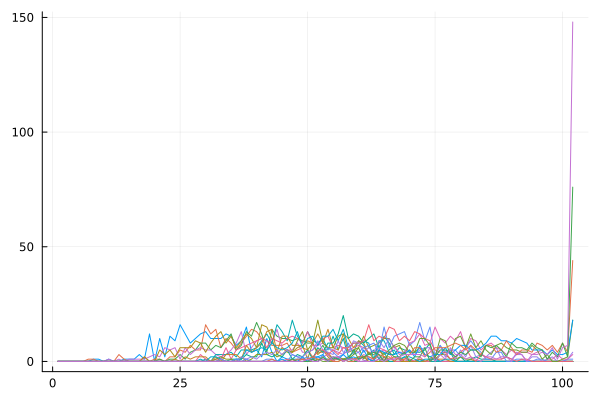

In [18]:
plot(results.en_histogram,legend=false)